<a href="https://colab.research.google.com/github/bigyunicorn/fastai22/blob/main/lesson04/NLP_Beginner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

In [ ]:
creds = '{"username":"<your kaggle user name>","key":"<your kaggle api key>"}'

In [ ]:
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [ ]:
# !kaggle competitions download -c us-patent-phrase-to-phrase-matching // this is bash command

In [ ]:
path = Path('us-patent-phrase-to-phrase-matching') #kaggle dataset data tab has this name at the end.

In [ ]:
if not iskaggle and not path.exists():
    import zipfile,kaggle 
    kaggle.api.competition_download_cli(str(path)) # this is the kagglge python library API
    zipfile.ZipFile(f'{path}.zip').extractall(path) # extract all files from zip

100%|██████████| 682k/682k [00:00<00:00, 34.7MB/s]

What i just did above is loading the kaggle dataset to google colab. The reason I chose this is a) I prefer google colab over kaggle and b) I think i have flexibility to get more GPU if i need to.

In [ ]:
!ls {path} # to see the file structure of Kaggle downloaded dataset

sample_submission.csv  test.csv  train.csv


Once I confirmed that the files are in csv, I am going to use pandas, as it is for handling csv files. Google Colab already installed pandas so I can skip `pip instal pandas` and directly import the library as pd.

In [ ]:
import pandas as pd #Colab has it installed already)

Then we are going to read the csv file into this notebook. 

In [ ]:
df = pd.read_csv(path/'train.csv')

In [ ]:
df

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


By default describe method only includes numerical value. By having object, I can include string.

In [ ]:
df.describe(include='object') 

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,37d61fd2272659b1,component composite coating,composition,H01
freq,1,152,24,2186


As an effort to convert the problem into NLP classification problem, we are going to concatenate each column value and create a new string per each row. This new string will be saved as a separate column called 'input'. 

In [ ]:
df['input'] = "TEXT1: " + df.context +"; TEXT2: " + df.target+ "; ANC1: " + df.anchor

In [ ]:
df.input.head() #dotted notation is one way to access a column in dataframe.

0    TEXT1: A47; TEXT2: abatement of pollution; ANC...
1    TEXT1: A47; TEXT2: act of abating; ANC1: abate...
2    TEXT1: A47; TEXT2: active catalyst; ANC1: abat...
3    TEXT1: A47; TEXT2: eliminating process; ANC1: ...
4    TEXT1: A47; TEXT2: forest region; ANC1: abatement
Name: input, dtype: object

In [ ]:
df['input'].head() #I can also access it like a dictionary

0    TEXT1: A47; TEXT2: abatement of pollution; ANC...
1    TEXT1: A47; TEXT2: act of abating; ANC1: abate...
2    TEXT1: A47; TEXT2: active catalyst; ANC1: abat...
3    TEXT1: A47; TEXT2: eliminating process; ANC1: ...
4    TEXT1: A47; TEXT2: forest region; ANC1: abatement
Name: input, dtype: object

Now, we have data that is representing the problem. The next work is to represent this data as number. 

To convert the text data to be numeric value, we need to go through two processes: tokenization and numericalization. How these processes are handled are very specific to models. So we need to choose a model first.  

 In this chapter, the way we are going to use is using HuggingFace Transformers library. This library provides a simple API to apply a wide range of state-of-the art pretrained NLP models to perform tasks (ex: text classification, summarization, translation and more). 

As such, we need to understand how this Transformers library API works. 

First and foremost, it accepts the data in the type called Dataset. 

A lot of utilites to work on Dataset are available via Datasets Huggingface library. 

Datasets library does provide a way to load the csv data simliar to Pands. According to ChatGPT, pandas is a good chocie for a small and simple CSV files (simple in a sense that the data that the file contains are straightforward data type unlike JSONs). As for our data, we confirmed that it is pretty small and the data itself is pretty primitive datatype, we decide to load csv files via pandas. 

This means we need to convert Dataframe object to Dataset. 

In [ ]:
!pip install -q datasets #installing huggingface dataset libraries; https://huggingface.co/docs/datasets/index

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 17.0 MB/s eta 0:00:00


In [ ]:
from datasets import Dataset
ds = Dataset.from_pandas(df)

In [ ]:
ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input'],
    num_rows: 36473
})

dataset of Transformer library is the same as dataframe of pandas. So I can do the following.

In [ ]:
ds['input']

['TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement',
 'TEXT1: A47; TEXT2: act of abating; ANC1: abatement',
 'TEXT1: A47; TEXT2: active catalyst; ANC1: abatement',
 'TEXT1: A47; TEXT2: eliminating process; ANC1: abatement',
 'TEXT1: A47; TEXT2: forest region; ANC1: abatement',
 'TEXT1: A47; TEXT2: greenhouse gases; ANC1: abatement',
 'TEXT1: A47; TEXT2: increased rate; ANC1: abatement',
 'TEXT1: A47; TEXT2: measurement level; ANC1: abatement',
 'TEXT1: A47; TEXT2: minimising sounds; ANC1: abatement',
 'TEXT1: A47; TEXT2: mixing core materials; ANC1: abatement',
 'TEXT1: A47; TEXT2: multi pollution abatement device; ANC1: abatement',
 'TEXT1: A47; TEXT2: noise reduction; ANC1: abatement',
 'TEXT1: A47; TEXT2: pollution abatement; ANC1: abatement',
 'TEXT1: A47; TEXT2: pollution abatement incinerator; ANC1: abatement',
 'TEXT1: A47; TEXT2: pollution certificate; ANC1: abatement',
 'TEXT1: A47; TEXT2: rent abatement; ANC1: abatement',
 'TEXT1: A47; TEXT2: sorbent material; ANC1:

Okay now we have Dataset, we need to choose a model. In this chapter, Jeremy chooses microsoft/deberta-v3-small. 

I was mainly curious about how to choose a model. And for me, the way I think it will work is checking the available models on HuggingFace. The list of models is available on Transformers documentation. ([link](https://huggingface.co/docs/transformers/v4.28.1/en/model_doc/deberta#overview)). 

How to find the full name is just using the name and search it and it will pop up. I think if the model is poular enough, i think there wil be a link (ALl model pages) that I can check out. I believe it is the same as the search results.

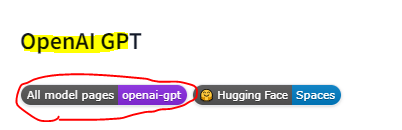

In [ ]:
model_nm = 'microsoft/deberta-v3-small'

Aight remember why we chose the model? It is because we want to token the input. But how do we know the right way to tokenize the input for microsoft/deberta-v3-small? 

This is where HuggingFace Transformers' library AutoTkoenizer class is useful. It is a class from Transformers library that provides a convenient way to automatically load the appropriate tokenizer for a given pre-trained model. 

In [ ]:
model_nm2 = 'microsoft/deberta-v3-large' # experiment

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.0 MB/s eta 0:00:00


In [ ]:
!pip install sentencepiece #https://github.com/huggingface/transformers/issues/9750 & restart the runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.3 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer
tokz = AutoTokenizer.from_pretrained(model_nm)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
tokz = AutoTokenizer.from_pretrained(model_nm2)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
tokz #name_or_path='microsoft/deberta-v3-small'

DebertaV2TokenizerFast(name_or_path='microsoft/deberta-v3-small', vocab_size=128000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [ ]:
tokz #microsoft/deberta-v3-large

DebertaV2TokenizerFast(name_or_path='microsoft/deberta-v3-large', vocab_size=128000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [ ]:
tokz.tokenize("hi my name is Yunny, and this is my own GoogleColab based on my own understanding.") #name_or_path='microsoft/deberta-v3-small'

['▁hi',
 '▁my',
 '▁name',
 '▁is',
 '▁Yun',
 'ny',
 ',',
 '▁and',
 '▁this',
 '▁is',
 '▁my',
 '▁own',
 '▁Google',
 'Cola',
 'b',
 '▁based',
 '▁on',
 '▁my',
 '▁own',
 '▁understanding',
 '.']

In [ ]:
tokz.tokenize("hi my name is Yunny, and this is my own GoogleColab based on my own understanding.") #microsoft/deberta-v3-large

['▁hi',
 '▁my',
 '▁name',
 '▁is',
 '▁Yun',
 'ny',
 ',',
 '▁and',
 '▁this',
 '▁is',
 '▁my',
 '▁own',
 '▁Google',
 'Cola',
 'b',
 '▁based',
 '▁on',
 '▁my',
 '▁own',
 '▁understanding',
 '.']

Aight so now we have a tokenizer for the model we are going to use! But as you can see, the tokenizer's tokenize function accetps a text. 

The input data we have is a table(dataset). The text we want to use is available in its column, 'input'. So let's create a function based on this.

In [ ]:
def tok_func(x): return tokz(x["input"])

this batched is important. We are familiar with map in python library. It is basically applying the given function to each element. But if you think about it, when there are a lot of elements, this can be a lot. So we want to apply the functino in a batch and do this in parallel.

And also remember, ds.map creates a new dataset.

In [ ]:
tok_ds = ds.map(tok_func, batched=True)

Map:   0%|          | 0/36473 [00:00<?, ? examples/s]

In [ ]:
tok_ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36473
})

In [ ]:
row = tok_ds[0]
row['input']

'TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement'

In [ ]:
row['input_ids']

[1,
 54453,
 435,
 294,
 336,
 5753,
 346,
 54453,
 445,
 294,
 47284,
 265,
 6435,
 346,
 23702,
 435,
 294,
 47284,
 2]

In [ ]:
tokz.vocab['▁of']

265

In [ ]:
tok_ds = tok_ds.rename_columns({'score':'labels'})

Transformers always assumes that your labels has the column name labels, but in our dataset it's currently score. Therefore, we need to rename it:

In [ ]:
tok_ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36473
})

okay now so far.. what we did are:
(1) Get the data from the kaggle
(2) Change the data to dataset
(3) choose a model
(4) tokenize the input. (so the data is ready)

Now the next step is.. we need to split the data for training between training and validation to avoid making our model to overfit into our training data. 

In Transformers library, it uses DatasetDict for holding training and validation sets. 

In [ ]:
dds = tok_ds.train_test_split(0.25, seed=42)

In [ ]:
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9119
    })
})

In [ ]:
eval_df = pd.read_csv(path/'test.csv')
eval_df.describe()

,id,anchor,target,context
count,36,36,36,36
unique,36,34,36,29
top,4112d61851461f60,el display,inorganic photoconductor drum,G02
freq,1,2,1,3


In [ ]:
eval_df['input'] = 'TEXT1: ' + eval_df.context + '; TEXT2: ' + eval_df.target + '; ANC1: ' + eval_df.anchor
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)

Map:   0%|          | 0/36 [00:00<?, ? examples/s]


okay now we have training set, validation set and test set, let's figure out a metric. So make sure to check each competition's evaluation part. 

At least for kaggle, it is given. In real life, it is our job to define and it can be harder. 



So for this particular, US Patent compeition, they are evaluating each model's prediction and the actual result on the Pearson correlation coefficient (r). 
I don't know the details about this from mathematically perspective, but the important information for me is that it tells me how two variables are related. -1 means perfect inverse correlation and +1 is perfect positive correlation. 

To calculate this value, we need numpy library as we are going to use np.corrcoef function.

In [ ]:
import numpy as np

In [ ]:
def corr(x,y): return np.corrcoef(x,y)[0][1]

In [ ]:
def corr_d(eval_pred): return {'pearson': corr(*eval_pred)} #the * in front of the variable gives the flexibility of # of parmaeters. 

In [ ]:
from transformers import TrainingArguments,Trainer

In [ ]:
bs = 128
epochs = 4

In [ ]:
lr = 8e-5

In [ ]:
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=0.01, report_to='none') #similar to data block + dataloaders 

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(model_nm2, num_labels=1)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                  tokenizer=tokz, compute_metrics=corr_d) #learner (model, data, metrics)
                

Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

In [ ]:
trainer.train(); # it is learner.learn, #name_or_path='microsoft/deberta-v3-small'

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.029247,0.797091
2,No log,0.025410,0.819541
3,0.037200,0.023342,0.828610
4,0.037200,0.022763,0.829926


In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 2            |        cudaMalloc retries: 4         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  14031 MiB |  14167 MiB |   7785 GiB |   7771 GiB |\n|       from large pool |  13986 MiB |  14104 MiB |   7675 GiB |   7662 GiB |\n|       from small pool |     45 MiB |     65 MiB |    109 GiB |    109 GiB |\n|---------------------------------------------------------------------------|\n| Active memory         |  14031 MiB |  14167 MiB |   7785 GiB |   7771 GiB |\n|       from large pool |  13986 MiB |  14104 MiB |

In [ ]:
trainer.train(); # it is learner.learn, #microsoft/deberta-v3-large

Epoch,Training Loss,Validation Loss,Pearson
1,0.046700,0.065751,0.009389
2,0.069900,0.066111,0.001826
3,0.068200,0.065691,0.019403
4,0.067900,0.065576,0.000742


In [ ]:
preds = trainer.predict(eval_ds).predictions.astype(float)
preds

array([[ 0.44775391],
       [ 0.68310547],
       [ 0.56201172],
       [ 0.33276367],
       [-0.0067749 ],
       [ 0.54833984],
       [ 0.53271484],
       [-0.01809692],
       [ 0.26342773],
       [ 1.08007812],
       [ 0.21899414],
       [ 0.28417969],
       [ 0.77392578],
       [ 0.87451172],
       [ 0.7265625 ],
       [ 0.46459961],
       [ 0.31787109],
       [-0.02246094],
       [ 0.66357422],
       [ 0.35253906],
       [ 0.40576172],
       [ 0.23913574],
       [ 0.21228027],
       [ 0.23974609],
       [ 0.57470703],
       [-0.01445007],
       [-0.0295105 ],
       [-0.03277588],
       [-0.0352478 ],
       [ 0.65722656],
       [ 0.37866211],
       [ 0.07519531],
       [ 0.67773438],
       [ 0.48657227],
       [ 0.44433594],
       [ 0.23400879]])

In [ ]:
preds = np.clip(preds, 0, 1) #this is simliar to using sigmoid function.

In [ ]:
preds

array([[0.44775391],
       [0.68310547],
       [0.56201172],
       [0.33276367],
       [0.        ],
       [0.54833984],
       [0.53271484],
       [0.        ],
       [0.26342773],
       [1.        ],
       [0.21899414],
       [0.28417969],
       [0.77392578],
       [0.87451172],
       [0.7265625 ],
       [0.46459961],
       [0.31787109],
       [0.        ],
       [0.66357422],
       [0.35253906],
       [0.40576172],
       [0.23913574],
       [0.21228027],
       [0.23974609],
       [0.57470703],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.65722656],
       [0.37866211],
       [0.07519531],
       [0.67773438],
       [0.48657227],
       [0.44433594],
       [0.23400879]])

In [ ]:
import datasets

submission = datasets.Dataset.from_dict({
    'id': eval_ds['id'],
    'score': preds
})

submission.to_csv('submission.csv', index=False)

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

1024